# Playlist Sorting

Log in:

In [20]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
import os
import numpy as np
from sklearn.preprocessing import normalize
import pandas as pd
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Use your own spotify dev data below!
# set open_browser=False to prevent Spotipy from attempting to open the default browser, authenticate with credentials
scope = 'user-library-read user-library-modify playlist-modify-public'

#credentials loaded from .env
load_dotenv('.env')
client_id = os.environ.get("client_id")
client_secret = os.environ.get("client_secret")
redirect_uri = os.environ.get("redirect_uri")
usernamevar = os.environ.get("usernamevar")

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri,scope=scope))

Define function:

In [21]:
def getPlaylistID(playlist_name, username=usernamevar):
    #Gets ID of playlist by name
    playlist_id = 'error'
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:  # iterate through playlists user follows
        if playlist['name'] == playlist_name:  # filter for newly created playlist
            playlist_id = playlist['id']
    print("Playlist ID found: ",playlist_id)
    if playlist_id=='error':
        raise
    return playlist_id

Select Playlist:

In [22]:
playlist_uri = getPlaylistID("Bot Sort Test") #Enter playist name to sort

Playlist ID found:  3IIh2xaaIWfDMBdrd2rYjI


Or set manually:

In [23]:
#playlist_uri = '00000000000'

Collect Data:

In [24]:
error_count = 0
song_data_input = []
offsetvar = 0

while offsetvar < 3000: #Max songs in playlist
    for song in sp.playlist_tracks(playlist_uri,offset=offsetvar,limit=100)["items"]:
        try: #get data for song
            song_features = sp.audio_features(song["track"]["id"])
        except: #in case of timeout
            print("Error for track: ", song["track"]["name"])
            error_count += 1 
            continue
        song_data_input.append([song["track"]["uri"],song_features[0]["tempo"],song_features[0]["loudness"],song_features[0]["acousticness"],song_features[0]["danceability"],song_features[0]["energy"],song_features[0]["instrumentalness"],song_features[0]["valence"]])
        #print("Added track ",song["track"]["name"]," to list")
        #print(sp.artist(song["track"]["artists"][0]['id'])['genres']) #Show Genres
    offsetvar += 100
#make numpy
array_full = np.array(song_data_input)

Visualize:

In [25]:
pd.DataFrame(normalize(array_full[:,1:],axis=0),columns=['tempo','loudness','acoustic','dance','energy','instrumental','valence'])

,tempo,loudness,acoustic,dance,energy,instrumental,valence
0,0.024457,-0.015015,0.010100,0.021400,0.015838,0.000000e+00,0.024026
1,0.022361,-0.023123,0.031320,0.016381,0.004903,2.022626e-02,0.003540
2,0.017688,-0.015447,0.000400,0.020199,0.020823,5.042117e-06,0.018630
3,0.013573,-0.018002,0.007090,0.017212,0.014240,1.129781e-05,0.006943
4,0.022076,-0.008088,0.001816,0.021154,0.017077,3.684068e-05,0.018011
...,...,...,...,...,...,...,...
2835,0.013136,-0.033456,0.039736,0.022262,0.002234,0.000000e+00,0.012374
2836,0.017555,-0.020923,0.029432,0.020846,0.017022,1.907047e-07,0.028976
2837,0.024975,-0.022611,0.020914,0.019922,0.016030,2.788334e-07,0.031450
2838,0.010733,-0.021316,0.035707,0.019553,0.011073,0.000000e+00,0.021964


Attempt 2:

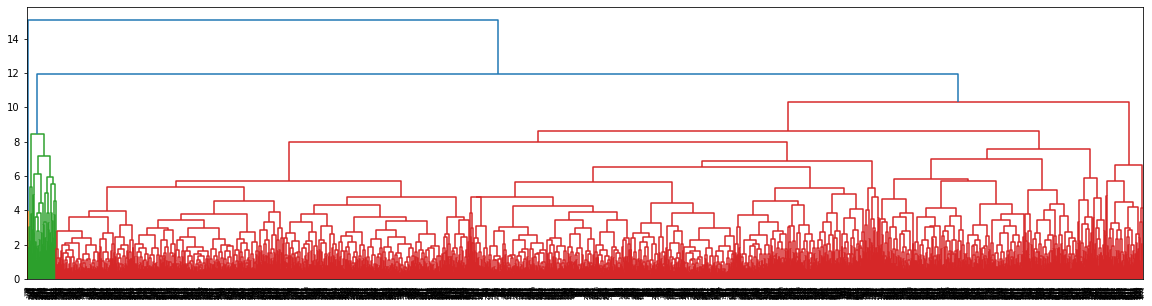

In [26]:
linkage = shc.linkage(normalize(array_full[:,1:],axis=0),method='complete',optimal_ordering=True,metric='seuclidean')
#linkage = shc.linkage(normalize(array_full[:,1:],axis=0),method='ward',optimal_ordering=True) #ALTERNATE METHOD
indexed = shc.leaves_list(linkage)
plt.figure(figsize=(20, 5))
dend = shc.dendrogram(linkage)

Make new list:

In [27]:
array_sorted = sorted(zip(indexed,array_full))

In [28]:
tracks_sorted = [item[1][0] for item in array_sorted]
tracks_unsorted = [item[0] for item in array_full]

Replace playlist:

In [29]:
for index,song in array_sorted:
    sp.playlist_reorder_items(playlist_uri,range_start=tracks_unsorted.index(song[0]),insert_before=int(index))
    tracks_unsorted.remove(song[0])
    tracks_unsorted.insert(int(index),song[0])

Verify lists:

In [32]:
print(tracks_sorted[:5])
print(tracks_unsorted[:5])
print([song["track"]["uri"] for song in sp.playlist_tracks(playlist_uri)["items"]][:5])

['spotify:track:1D3wLZMFsFnoPXlS93DBHp', 'spotify:track:1XYUtOmrYOjSfeygulpLTA', 'spotify:track:48sc7vBJeNoCEQhxO3zYKA', 'spotify:track:5PdZuVQMXk0q6Cw0AuwPov', 'spotify:track:1lNpREl86qbYCmcf8KOxyq']
['spotify:track:1D3wLZMFsFnoPXlS93DBHp', 'spotify:track:1XYUtOmrYOjSfeygulpLTA', 'spotify:track:48sc7vBJeNoCEQhxO3zYKA', 'spotify:track:5PdZuVQMXk0q6Cw0AuwPov', 'spotify:track:1lNpREl86qbYCmcf8KOxyq']
['spotify:track:1D3wLZMFsFnoPXlS93DBHp', 'spotify:track:1XYUtOmrYOjSfeygulpLTA', 'spotify:track:48sc7vBJeNoCEQhxO3zYKA', 'spotify:track:5PdZuVQMXk0q6Cw0AuwPov', 'spotify:track:1lNpREl86qbYCmcf8KOxyq']
